#Etapa 1: Importação das bibliotecas

In [34]:
import numpy as np              #lib cienfífica do python
import math                     #para ter-mos acesso a recursosd e calculos matemáticos
import re                       #porque vamos trabalhar com expressões regulares
import pandas as pd             #para carregar a base de dados
from bs4 import BeautifulSoup   #é usada pra se fazer preprocessamento em textos
from google.colab import drive  #para termos acesso de recursos do google drive
import zipfile                  #para poder descompactar arquivos .zip
import seaborn as sns           #para visualização de gráficos
import spacy as sp              #é uma lib de processamento de linguagem natural que será usada para fazer o preprocessamento em alguns textos
import string                   #vai ser usada para o pré processamento dos textos
import random                   #para números aleatórios
import matplotlib.pyplot as plt #usada para gerar gráficos
from sklearn.model_selection import train_test_split

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.6.0'

In [3]:
from tensorflow.keras import layers   #para ter-mos acesso as camadas
import tensorflow_datasets as tfds    

# **Etapa 2: Pré-processamento dos dos dados**

## **Carregamento Dos Arquivos**

In [6]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
path = '/content/drive/MyDrive/Database/trainingandtestdata.zip'
zip_object = zipfile.ZipFile(file = path, mode='r') #r pq será feito uma leitura
zip_object.extractall('./')
zip_object.close()

In [8]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [9]:
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', header= None, names= cols, engine='python', encoding='latin1')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


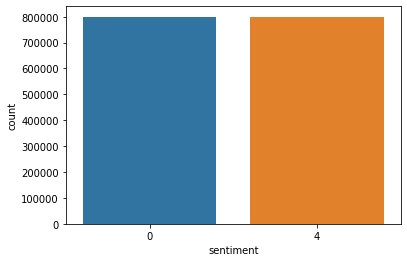

In [12]:
sns.countplot(train_data.sentiment);

In [13]:
test_data = pd.read_csv("/content/trainingandtestdata/test.csv", header=None, names=cols, engine="python", encoding="latin1")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


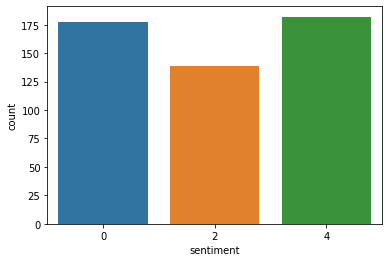

In [14]:
sns.countplot(test_data.sentiment);

## **Limpeza**

In [15]:
data = train_data #para trabalhar com essa variável

In [16]:
data.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True);

In [17]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [41]:
X = data.iloc[:, 1].values

In [28]:
X.shape
type(X)

numpy.ndarray

In [42]:
y = data.iloc[:, 0].values

In [33]:
X.shape
y

array([0, 0, 0, ..., 4, 4, 4])

In [44]:
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y) #vamos returar 85% da base de dados. X e y representam a porção de treinamento e _ e _ a porção de teste.
#esse estratify vai fazer com que seja dividido de forma igual as classes, não fique mais demais de um lado e menos no outro

In [45]:
X.shape

(240000,)

In [47]:
y.shape

(240000,)

In [48]:
unique, counts = np.unique(y, return_counts= True)
unique, counts

(array([0, 4]), array([120000, 120000]))